# Probabilistic flood risk assessment

In this notebook, we combine the forecasting abilities and the time series analysis capabilities in a single seamless process to estimate the flood risk of a probabilistic forecast. As an example, we first perform a frequency analysis on an observed time series, then estimate the streamflow associated to a 2-year return period. We then perform a climatological ESP forecast (to ensure repeatability, but a realtime forecast would work too!) and estimate the probability of flooding (exceeding the threshold) given the ensemble of members in the probabilistic forecast.

In [1]:
import warnings

from numba.core.errors import NumbaDeprecationWarning

warnings.simplefilter("ignore", category=NumbaDeprecationWarning)

In [2]:
%matplotlib inline

import datetime as dt

import xclim
from matplotlib import pyplot as plt

from ravenpy.utilities.testdata import get_file, open_dataset

Perform the time series analysis on observed data for the catchment using the frequency analysis WPS capabilities.

In [3]:
# Get the data that we will be using for the demonstration.
file = "raven-gr4j-cemaneige/Salmon-River-Near-Prince-George_meteo_daily.nc"
ts = open_dataset(file).qobs

# Perform the frequency analysis for various return periods. We compute 2, 5, 10, 25, 50 and 100 year return
# periods, but later on we will only compare the forecasts to the 2 year return period.
out = xclim.generic.return_level(
    ts, mode="max", t=(2, 5, 10, 25, 50, 100), dist="gumbel_r"
)
out

<xarray.DataArray 'fa_1maxannual' (return_period: 6)>
array([186.42526386, 283.04234564, 347.01126071, 427.83615447,
       487.79667785, 547.31446213])
Coordinates:
  * return_period  (return_period) int64 2 5 10 25 50 100
Attributes:
    units:               m**3 s**-1
    original_long_name:  discharge observation
    long_name:           N-year return level
    description:         Frequency analysis for the maximal annual 1-day valu...
    method:              ML
    estimator:           Maximum likelihood
    scipy_dist:          gumbel_r
    history:             [2023-05-31 13:22:25] fa_1maxannual: xclim.core.indi...
    cell_methods:        
    mode:                max

Threshold: 186.4


Text(25, 10, 'Flow threshold, set at 2-year return period')

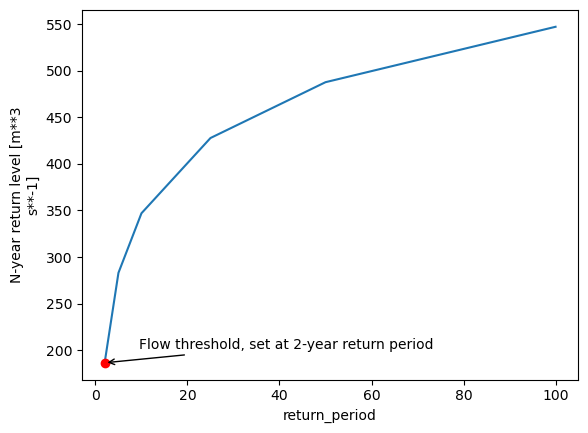

In [4]:
# Plot the results of the flows as a function of return period.
fig, ax = plt.subplots(1)
lines = out.plot(ax=ax)

# Get 2-year return period from the frequency analysis
threshold = out.sel(return_period=2).values
print(f"Threshold: {threshold:.1f}")

pt = ax.plot([2], [threshold], "ro")

ax.annotate(
    "Flow threshold, set at 2-year return period",
    (2, threshold),
    xytext=(25, 10),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
)

## Probabilistic forecast

In this example, we will perform an ensemble hydrological forecast and will then compute the probability of flooding given a flooding threshold. Start by building the model configuration as in the Tutorial Notebook 11:

In [5]:
from ravenpy.config import commands as rc
from ravenpy.config.emulators import GR4JCN
from ravenpy.utilities.forecasting import climatology_esp, compute_forecast_flood_risk

# Choose the forecast date. Each forecast will start with the same day and month.
# For example, jan-05-2001 will compare the climatology using all jan-05ths from the dataset)
fdate = dt.datetime(2003, 4, 13)

# The dataset to use to get the forecast timeseries:
duration = 30  # Length in days of the climatological ESP forecast

# Define HRU to build the hydrological model
hru = dict(
    area=4250.6,
    elevation=843.0,
    latitude=54.4848,
    longitude=-123.3659,
    hru_type="land",
)

# Set alternative names for netCDF variables
alt_names = {
    "TEMP_MIN": "tmin",
    "TEMP_MAX": "tmax",
    "RAINFALL": "rain",
    "SNOWFALL": "snow",
}

# Data types to extract from netCDF
data_type = ["TEMP_MAX", "TEMP_MIN", "RAINFALL", "SNOWFALL"]
data_kwds = {
    "ALL": {
        "elevation": hru[
            "elevation"
        ],  # No need for lat/lon as they are included in the netcdf file already
    }
}
# Model configuration
model_config = GR4JCN(
    params=[0.529, -3.396, 407.29, 1.072, 16.9, 0.947],
    Gauge=[
        rc.Gauge.from_nc(
            get_file(file),
            data_type=data_type,
            alt_names=alt_names,
            data_kwds=data_kwds,
        )
    ],
    HRUs=[hru],
    StartDate=fdate,
    Duration=duration,
    RunName="Probabilistic_flood_risk_NB",
)

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


Now that the configuration is ready, launch the ESP forecasting tool to generate an ensemble hydrological forecast:

In [6]:
# Launch the ESP forecasting method
ESP_sims = climatology_esp(
    config=model_config,
)

# Show the results in an xarray dataset, ready to use:
ESP_sims.hydrograph

<xarray.Dataset>
Dimensions:     (member: 57, time: 31, nbasins: 1)
Coordinates:
  * member      (member) int64 1954 1955 1956 1957 1958 ... 2007 2008 2009 2010
  * time        (time) datetime64[ns] 2003-04-13 2003-04-14 ... 2003-05-13
    basin_name  (nbasins) object 'sub_001'
Dimensions without coordinates: nbasins
Data variables:
    precip      (member, time) float64 nan 0.2054 0.0 4.304 ... 0.0 0.0 0.0 0.0
    q_sim       (member, time, nbasins) float64 0.0 0.1644 ... 0.5947 0.5763
    q_obs       (member, time, nbasins) float64 nan nan nan nan ... nan nan nan
    q_in        (member, time, nbasins) float64 nan nan nan nan ... nan nan nan
Attributes:
    Conventions:  CF-1.6
    featureType:  timeSeries
    history:      Created on 2023-05-31T13:22:36 by Raven 3.7
    description:  Standard Output
    references:   Craig J.R. and the Raven Development Team Raven user's and ...
    model_id:     GR4JCN

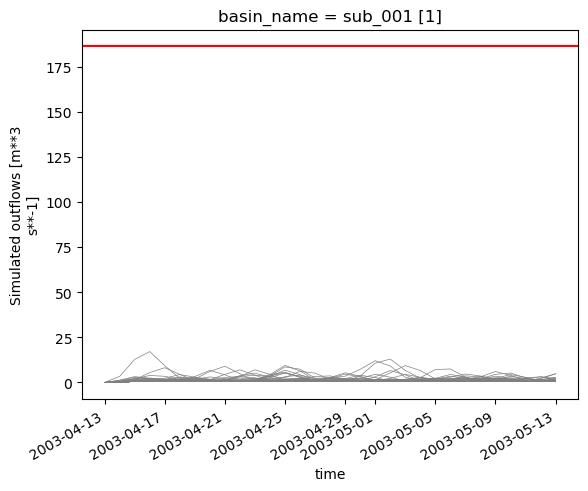

In [7]:
# Plot the forecasts and the 2-year threshold previously estimated
fig, ax = plt.subplots(1)
ESP_sims.hydrograph.q_sim[:, :, 0].plot.line(
    ax=ax, hue="member", add_legend=False, color="gray", lw=0.5
)
t = ax.axhline(threshold, color="red")

Text(0, 0.5, 'Flood risk')

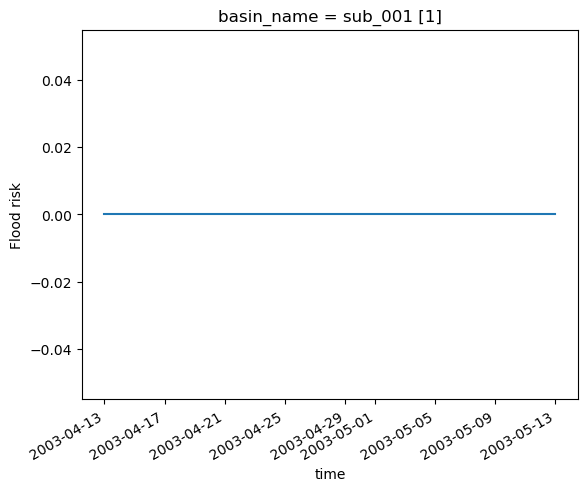

In [8]:
# Now compute the flood risk given the probabilistic forecast and the threshold associated to the 2-year return
# period.

threshold = out.sel(return_period=2).values

# Run the flood forecast risk tool to extract the probability of exceedance in netcdf format and xarray Dataset format
flood_risk_data = compute_forecast_flood_risk(
    forecast=ESP_sims.hydrograph.q_sim,
    flood_level=threshold,
)

# Extract the data and plot
fig, ax = plt.subplots(1)
l = flood_risk_data.exceedance_probability.plot()
ax.set_ylabel("Flood risk")

### Results analysis
We can see from the above figure that there is no risk of exceeding the 2-year return period for the selected dates of the forecast.
